# 4-7. 프로젝트: 멋진 작사가 만들기

## Step 1. 데이터 다운로드

## Step 2. 데이터 읽어오기

In [1]:
import glob
import os
import re
import numpy as np
import tensorflow as tf

txt_file_path = os.getenv('HOME')+'/aiffel/lyricist/data/lyrics/*'

txt_list = glob.glob(txt_file_path)

raw_corpus = []


# 여러개의 txt 파일을 모두 읽어서 raw_corpus 에 담습니다.
for txt_file in txt_list:
    with open(txt_file, "r") as f:
        raw = f.read().splitlines()
        raw_corpus.extend(raw)
print("데이터 크기:", len(raw_corpus))
print("Examples:\n", raw_corpus[:9])

데이터 크기: 187088
Examples:
 ["Now I've heard there was a secret chord", 'That David played, and it pleased the Lord', "But you don't really care for music, do you?", 'It goes like this', 'The fourth, the fifth', 'The minor fall, the major lift', 'The baffled king composing Hallelujah Hallelujah', 'Hallelujah', 'Hallelujah']


## Step 3. 데이터 정제

In [2]:
for idx, sentence in enumerate(raw_corpus[0:9]):
    if len(sentence) == 0: continue   # 길이가 0인 문장은 건너뜁니다.
    if sentence[-1] == ":": continue  # 문장의 끝이 : 인 문장은 건너뜁니다. 여기서는 생략해도 됨

    if idx > 9: break   # 일단 문장 10개만 확인해 볼 겁니다.
        
    print(idx, sentence)

0 Now I've heard there was a secret chord
1 That David played, and it pleased the Lord
2 But you don't really care for music, do you?
3 It goes like this
4 The fourth, the fifth
5 The minor fall, the major lift
6 The baffled king composing Hallelujah Hallelujah
7 Hallelujah
8 Hallelujah


In [3]:
# 전처리를 위해 정규표현식(Regex)

# 입력된 문장을
#     1. 소문자로 바꾸고, 양쪽 공백을 지웁니다
#     2. 특수문자 양쪽에 공백을 넣고
#     3. 여러개의 공백은 하나의 공백으로 바꿉니다
#     4. a-zA-Z?.!,¿가 아닌 모든 문자를 하나의 공백으로 바꿉니다
#     5. 다시 양쪽 공백을 지웁니다
#     6. 문장 시작에는 <start>, 끝에는 <end>를 추가합니다
# 이 순서로 처리해주면 문제가 되는 상황을 방지할 수 있겠네요!
def preprocess_sentence(sentence):
    sentence = sentence.lower().strip() # 1
    sentence = re.sub(r"([?.!,¿])", r" \1 ", sentence) # 2
    sentence = re.sub(r'[" "]+', " ", sentence) # 3
    sentence = re.sub(r"[^a-zA-Z?.!,¿]+", " ", sentence) # 4
    sentence = sentence.strip() # 5
    sentence = '<start> ' + sentence + ' <end>' # 6
    return sentence

## 토큰화 했을 때 토큰의 개수가 15개를 넘어가는 문장을 학습 데이터에서 제외하기

+ 토큰의 개수가 4개 이상 15개 이하 인 것만 남김( 단어수가 2개 이상 or 13개 이하인것)

In [4]:
# 여기에 정제된 문장을 모을겁니다 소스문장
corpus = []

for sentence in raw_corpus:
    # 우리가 원하지 않는 문장은 건너뜁니다
    if len(sentence) == 0: continue
    
    
    # 정제를 하고 담아주세요
    preprocessed_sentence = preprocess_sentence(sentence)
    
    # 토큰 4개 이상 15개 이하 인 문장 -> [4:15]
    if preprocessed_sentence.count(' ')+1 < 4  : continue
    if preprocessed_sentence.count(' ')+1 > 16 : continue
        
    corpus.append(preprocessed_sentence)
        
# 정제된 결과를 10개만 확인해보죠
print(len(corpus))

corpus[:10]


158061


['<start> now i ve heard there was a secret chord <end>',
 '<start> that david played , and it pleased the lord <end>',
 '<start> but you don t really care for music , do you ? <end>',
 '<start> it goes like this <end>',
 '<start> the fourth , the fifth <end>',
 '<start> the minor fall , the major lift <end>',
 '<start> the baffled king composing hallelujah hallelujah <end>',
 '<start> hallelujah your faith was strong but you needed proof <end>',
 '<start> you saw her bathing on the roof <end>',
 '<start> her beauty and the moonlight overthrew her <end>']

In [5]:
# 토큰화 할 때 텐서플로우의 Tokenizer와 pad_sequences를 사용합니다
# 더 잘 알기 위해 아래 문서들을 참고하면 좋습니다
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/text/Tokenizer
# https://www.tensorflow.org/api_docs/python/tf/keras/preprocessing/sequence/pad_sequences
def tokenize(corpus):
    # 7000단어를 기억할 수 있는 tokenizer를 만들겁니다
    # 우리는 이미 문장을 정제했으니 filters가 필요없어요
    # 7000단어에 포함되지 못한 단어는 '<unk>'로 바꿀거에요
    tokenizer = tf.keras.preprocessing.text.Tokenizer(
        num_words=12000, 
        filters=' ',
        oov_token="<unk>"
    )
    # corpus를 이용해 tokenizer 내부의 단어장을 완성합니다
    tokenizer.fit_on_texts(corpus)
    
    # 준비한 tokenizer를 이용해 corpus를 Tensor로 변환합니다
    tensor = tokenizer.texts_to_sequences(corpus)   
    
    # 입력 데이터의 시퀀스 길이를 일정하게 맞춰줍니다
    # 만약 시퀀스가 짧다면 문장 뒤에 패딩을 붙여 길이를 맞춰줍니다.
    # 문장 앞에 패딩을 붙여 길이를 맞추고 싶다면 padding='pre'를 사용합니다
    tensor = tf.keras.preprocessing.sequence.pad_sequences(tensor, padding='post')  
    
    print(tensor,tokenizer)
    return tensor, tokenizer

tensor, tokenizer = tokenize(corpus)

[[   2   49    4 ...    0    0    0]
 [   2   15 2868 ...    0    0    0]
 [   2   32    7 ...    3    0    0]
 ...
 [   2    4  115 ...    0    0    0]
 [   2  260  189 ...    3    0    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc9e08e2a60>


In [6]:
tensor, tokenizer = tokenize(corpus)

tensor.shape

[[   2   49    4 ...    0    0    0]
 [   2   15 2868 ...    0    0    0]
 [   2   32    7 ...    3    0    0]
 ...
 [   2    4  115 ...    0    0    0]
 [   2  260  189 ...    3    0    0]
 [   2    7   34 ...    0    0    0]] <keras_preprocessing.text.Tokenizer object at 0x7fc9e0903910>


(158061, 16)

In [7]:
# tokenizer에 구축된 단어 사전의 인덱스 확인

for idx in tokenizer.index_word:
    print(idx, ":", tokenizer.index_word[idx])

    if idx >= 10: break

1 : <unk>
2 : <start>
3 : <end>
4 : i
5 : ,
6 : the
7 : you
8 : and
9 : a
10 : to


# Step 4. 평가 데이터셋 분리

validation 검증을 위해 나눈다

In [8]:
# tensor에서 마지막 토큰을 잘라내서 소스 문장을 생성합니다
# 마지막 토큰은 <end>가 아니라 <pad>일 가능성이 높습니다.
src_input = tensor[:, :-1]  
# tensor에서 <start>를 잘라내서 타겟 문장을 생성합니다.
tgt_input = tensor[:, 1:]  

from sklearn.model_selection import train_test_split
enc_train, enc_val, dec_train, dec_val = train_test_split(src_input, tgt_input, test_size=0.2, random_state=42)
print("Source Train:", enc_train.shape)
print("Target Train:", dec_train.shape)
print("Source Val:", enc_val.shape)
print("Target Val:", dec_val.shape)


Source Train: (126448, 15)
Target Train: (126448, 15)
Source Val: (31613, 15)
Target Val: (31613, 15)


## corpus 텐서를 tf.data.Dataset객체로 변환
주의 : enc_train, dec_train 값을 넣어줘야 올바른 validation을 알 수 있다

In [9]:

BUFFER_SIZE = len(enc_train)
BATCH_SIZE = 256
steps_per_epoch = len(enc_train) // BATCH_SIZE

 # tokenizer가 구축한 단어사전 내 14000, 여기 포함되지 않은 0:<pad>를 포함하여 7001개
VOCAB_SIZE = tokenizer.num_words + 1   

# 준비한 데이터 소스로부터 데이터셋을 만듭니다
# 데이터셋에 대해서는 아래 문서를 참고하세요
# 자세히 알아둘수록 도움이 많이 되는 중요한 문서입니다
# https://www.tensorflow.org/api_docs/python/tf/data/Dataset
dataset = tf.data.Dataset.from_tensor_slices((enc_train, dec_train))
dataset = dataset.shuffle(BUFFER_SIZE)
dataset = dataset.batch(BATCH_SIZE, drop_remainder=True)
dataset

<BatchDataset shapes: ((256, 15), (256, 15)), types: (tf.int32, tf.int32)>

## Step 5. 인공지능 만들기

데이터 
+ Source Train: (126448, 15)
+ Target Train: (126448, 15)
+ Source Val: (31613, 15)
+ Target Val: (31613, 15)

RNN 레이어 2개
+ embedding_size = 256
+ hidden_size = 1024
+ n_train_epoch = 10

In [10]:
class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)
        self.rnn_1 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.rnn_2 = tf.keras.layers.LSTM(hidden_size, return_sequences=True)
        self.linear = tf.keras.layers.Dense(vocab_size)
        
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

하이퍼 파라미터 지정과 모델 생성
+ embedding_size를 256으로 올려 고려하는 feature의 수를 늘림
+ hidden_size를 2048로 올려 각 레이어의 노드 수를 늘림

In [12]:
embedding_size = 256
hidden_size = 1024
model_RNN = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

for src_sample, tgt_sample in dataset.take(1): break
    
output = model_RNN(src_sample)

print(f'Shape of model output : {output.shape}\n')
model_RNN.summary()

Shape of model output : (256, 15, 12001)

Model: "text_generator_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_1 (Embedding)      multiple                  3072256   
_________________________________________________________________
lstm_2 (LSTM)                multiple                  5246976   
_________________________________________________________________
lstm_3 (LSTM)                multiple                  8392704   
_________________________________________________________________
dense_1 (Dense)              multiple                  12301025  
Total params: 29,012,961
Trainable params: 29,012,961
Non-trainable params: 0
_________________________________________________________________


In [13]:
tf.test.is_gpu_available()

Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

In [14]:
optimizer = tf.keras.optimizers.Adam()
# optimizer = tf.keras.optimizers.SGD()
loss = tf.keras.losses.SparseCategoricalCrossentropy(
    from_logits=True, reduction='none')

## 모델 학습

### 모델 저장

In [15]:
model_RNN.compile(loss=loss, optimizer=optimizer)

In [16]:
checkpoint_path = "trainingRNN/RNN.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

RNN_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

In [17]:
history_RNN = model_RNN.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128,
          callbacks=[RNN_callback], validation_data = (enc_val, dec_val) )

Epoch 1/10
988/988 [==============================] - 104s 103ms/step - loss: 3.1925 - val_loss: 2.9161

Epoch 00001: saving model to trainingRNN/RNN.ckpt
Epoch 2/10
988/988 [==============================] - 110s 112ms/step - loss: 2.7977 - val_loss: 2.7379

Epoch 00002: saving model to trainingRNN/RNN.ckpt
Epoch 3/10
988/988 [==============================] - 110s 111ms/step - loss: 2.6196 - val_loss: 2.6287

Epoch 00003: saving model to trainingRNN/RNN.ckpt
Epoch 4/10
988/988 [==============================] - 110s 111ms/step - loss: 2.4756 - val_loss: 2.5526

Epoch 00004: saving model to trainingRNN/RNN.ckpt
Epoch 5/10
988/988 [==============================] - 110s 111ms/step - loss: 2.3486 - val_loss: 2.4951

Epoch 00005: saving model to trainingRNN/RNN.ckpt
Epoch 6/10
988/988 [==============================] - 110s 111ms/step - loss: 2.2333 - val_loss: 2.4503

Epoch 00006: saving model to trainingRNN/RNN.ckpt
Epoch 7/10
988/988 [==============================] - 110s 111ms/step 

# 다른 모델 선정
다른 사람이 한 것을 참고했습니다

Bi LSTM 레이어 2개

+ embedding_size = 256
+ hidden_size = 1024
+ n_train_epoch = 10

In [18]:
from tensorflow.keras.layers import Bidirectional, LSTM

class TextGenerator(tf.keras.Model):
    def __init__(self, vocab_size, embedding_size, hidden_size):
        super().__init__()
        
        self.embedding = tf.keras.layers.Embedding(vocab_size, embedding_size)    # 단어사전에 의해 변환된 숫자를 벡터로 변환
        self.rnn_1 = Bidirectional(LSTM(hidden_size, return_sequences=True))     # Bi-LSMT Layer 
        self.rnn_2 = Bidirectional(LSTM(hidden_size, return_sequences=True))     # Bi-LSMT Layer
        self.linear = tf.keras.layers.Dense(vocab_size)                           # 출력 및 단어 예측을 위한 Fully-Connected Layer
    
    def call(self, x):
        out = self.embedding(x)
        out = self.rnn_1(out)
        out = self.rnn_2(out)
        out = self.linear(out)
        
        return out

In [19]:
embedding_size = 256
hidden_size = 1024
model_LSTM = TextGenerator(tokenizer.num_words + 1, embedding_size , hidden_size)

for src_sample, tgt_sample in dataset.take(1): break
    
output = model_LSTM(src_sample)


print(f'Shape of model output : {output.shape}\n')
model_LSTM.summary()

Shape of model output : (256, 15, 12001)

Model: "text_generator_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_2 (Embedding)      multiple                  3072256   
_________________________________________________________________
bidirectional (Bidirectional multiple                  10493952  
_________________________________________________________________
bidirectional_1 (Bidirection multiple                  25174016  
_________________________________________________________________
dense_2 (Dense)              multiple                  24590049  
Total params: 63,330,273
Trainable params: 63,330,273
Non-trainable params: 0
_________________________________________________________________


In [20]:
optimizer = tf.keras.optimizers.Adam()                     # Optimizer로 Adam 사용
loss = tf.keras.losses.SparseCategoricalCrossentropy(      # Loss함수로 CrossEntropy함수 사용
    from_logits=True, reduction='none')                   

model_LSTM.compile(loss=loss, optimizer=optimizer, metrics=['accuracy'])


## 모델 학습
모델의 학습시간이 매우 길어서 다양한 문제가 발생할 것으로 판단 됨.

1.모델이 학습을 하던 중 외부요인에 의해 학습이 중단될 경우
> 학습 중간에 현재 state의 가중치값을 저장하여 중간이 되어도 중간부터 진행할 수 있도록 조치

2.하이퍼파라미터를 수정하며 다양한 실험을 한 후에 결과값을 비교할 필요가 있는 경우
>모델의 학습 결과를 pickle 자료형으로 저장하여 이후에 분석을 할 때 불러와 비교분석 실시

모델 저장



In [21]:
checkpoint_path = "training_LSTM/LSTM.ckpt"             # 저장할 가중치의 확장자 및 파일 이름
checkpoint_dir = os.path.dirname(checkpoint_path)  # 저장할 경로

lstm_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path, # 학습 시 callback함수를 반환하여 학습
                                                 save_weights_only=True,
                                                 verbose=1)

In [23]:
# 모델 학습

history_lstm = model_LSTM.fit(x = enc_train, y = dec_train, epochs=10, batch_size=128,
                              callbacks=[lstm_callback], validation_data=(enc_val, dec_val))

Epoch 1/10
988/988 [==============================] - 253s 252ms/step - loss: 1.2033 - accuracy: 0.8195 - val_loss: 0.3139 - val_accuracy: 0.9508

Epoch 00001: saving model to training_LSTM/LSTM.ckpt
Epoch 2/10
988/988 [==============================] - 248s 251ms/step - loss: 0.1751 - accuracy: 0.9693 - val_loss: 0.1604 - val_accuracy: 0.9738

Epoch 00002: saving model to training_LSTM/LSTM.ckpt
Epoch 3/10
988/988 [==============================] - 248s 251ms/step - loss: 0.0466 - accuracy: 0.9905 - val_loss: 0.1191 - val_accuracy: 0.9809

Epoch 00003: saving model to training_LSTM/LSTM.ckpt
Epoch 4/10
988/988 [==============================] - 248s 251ms/step - loss: 0.0090 - accuracy: 0.9984 - val_loss: 0.1122 - val_accuracy: 0.9820

Epoch 00004: saving model to training_LSTM/LSTM.ckpt
Epoch 5/10
988/988 [==============================] - 248s 251ms/step - loss: 0.0102 - accuracy: 0.9979 - val_loss: 0.1195 - val_accuracy: 0.9800

Epoch 00005: saving model to training_LSTM/LSTM.ckpt


학습결과 저장 및 불러오기

In [24]:
import pickle

with open('RNN_training.pkl', 'wb') as f: # 학습결과 pkl 형식으로 저장(dictionary 자료형 -> pkl 자료형)
    pickle.dump(history_RNN.history, f)

with open('RNN_training.pkl', 'rb') as f: # 저장된 pkl 데이터 불러오기(pkl 자료형 -> dictionary 자료형)
    history_RNN = pickle.load(f)

In [25]:
with open('lstm_training2.pkl', 'wb') as f: # 학습결과 pkl 형식으로 저장(dictionary 자료형 -> pkl 자료형)
    pickle.dump(history_lstm.history, f)

with open('lstm_training2.pkl', 'rb') as f: # 저장된 pkl 데이터 불러오기(pkl 자료형 -> dictionary 자료형)
    history_lstm2 = pickle.load(f)
    
# with open('bi_lstm_training.pkl', 'rb') as f: # 저장된 pkl 데이터 불러오기(pkl 자료형 -> dictionary 자료형)
#     history_bi = pickle.load(f)

## Loss value 시각화

val_loss 값을 2.2 수준으로 낮추기

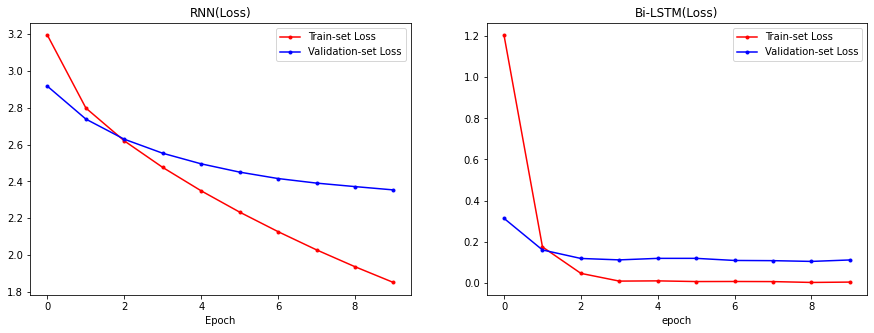

In [26]:
import matplotlib.pyplot as plt

plt.figure(figsize=(15,5))

plt.subplot(1,2,1)
plt.plot(history_RNN['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history_RNN['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('Epoch')
plt.legend()
plt.title('RNN(Loss)')


plt.subplot(1,2,2)
plt.plot(history_lstm2['loss'], marker='.', c='red', label='Train-set Loss')
plt.plot(history_lstm2['val_loss'], marker='.', c='blue', label='Validation-set Loss')
plt.xlabel('epoch')
plt.legend()
plt.title('Bi-LSTM(Loss)')

plt.show()

## 잘 만들어졌는지 평가하기

In [27]:
def generate_text(model, tokenizer, init_sentence="<start>", max_len=20):
    # 테스트를 위해서 입력받은 init_sentence도 텐서로 변환합니다
    test_input = tokenizer.texts_to_sequences([init_sentence])
    test_tensor = tf.convert_to_tensor(test_input, dtype=tf.int64)
    end_token = tokenizer.word_index["<end>"]

    # 단어 하나씩 예측해 문장을 만듭니다
    #    1. 입력받은 문장의 텐서를 입력합니다
    #    2. 예측된 값 중 가장 높은 확률인 word index를 뽑아냅니다
    #    3. 2에서 예측된 word index를 문장 뒤에 붙입니다
    #    4. 모델이 <end>를 예측했거나, max_len에 도달했다면 문장 생성을 마칩니다
    while True:
        # 1
        predict = model(test_tensor) 
        # 2
        predict_word = tf.argmax(tf.nn.softmax(predict, axis=-1), axis=-1)[:, -1] 
        # 3 
        test_tensor = tf.concat([test_tensor, tf.expand_dims(predict_word, axis=0)], axis=-1)
        # 4
        if predict_word.numpy()[0] == end_token: break
        if test_tensor.shape[1] >= max_len: break

    generated = ""
    # tokenizer를 이용해 word index를 단어로 하나씩 변환합니다 
    for word_index in test_tensor[0].numpy():
        generated += tokenizer.index_word[word_index] + " "

    return generated

In [28]:
RNN_checkpoint = "trainingRNN/RNN.ckpt"               # 일반 LSTM 가중치값 저장 경로
model_RNN.load_weights(RNN_checkpoint)         # 모델에 가중치 대입


LSTM_checkpoint = "training_LSTM/LSTM.ckpt"      # BI LSTM 가중치값 저장 경로
model_LSTM.load_weights(LSTM_checkpoint)   # 모델에 가중치 대입

In [29]:
keywords = [
    'That you were',
    'I got',
    'I keep waiting',
    "I've started talking",
    "I'm right here for you",
    'Do you wanna build',
    'Please, I don’t want to',
    'Just go to the',
    'Why should I',
    "It's a good day"]
for start in keywords:
    print(generate_text(model_RNN, tokenizer, init_sentence= ' '.join(["<start>", start])))

<start> that you were in the <unk> <end> 
<start> i got the cleanest meanest penis you reel me <end> 
<start> i keep waiting for it , that green light , i want it <end> 
<start> <unk> started talking bout linda <end> 
<start> <unk> right here for you to die <end> 
<start> do you wanna build a snowman ? <end> 
<start> <unk> i <unk> want to be <unk> <end> 
<start> just go to the zoo , but you re the only one <end> 
<start> why should i do ? <end> 
<start> <unk> a good day <end> 


In [30]:
keywords = [
    'That you were',
    'I got',
    'I keep waiting',
    "I've started talking",
    "I'm right here for you",
    'Do you wanna build',
    'Please, I don’t want to',
    'Just go to the',
    'Why should I',
    "It's a good day"]
for start in keywords:
    print(generate_text(model_LSTM, tokenizer, init_sentence= ' '.join(["<start>", start])))

<start> that you were <end> 
<start> i got <end> 
<start> i keep waiting <end> 
<start> <unk> started talking <end> 
<start> <unk> right here for you <end> 
<start> do you wanna build <end> 
<start> <unk> i <unk> want to <end> 
<start> just go to the <end> 
<start> why should i <end> 
<start> <unk> a good day <end> 


## 회고
+ LSTM모델이 Loss가 더 작은 결과를 보여주었다
+ 하지만 Loss 값이 더 좋은 모델이 실제 문장 평가에서는 좋지 않은 결과를 보여주었다.
     - 이것에 대한 결과는 데이터 양의 문제일 수 있다.